# Diffusion Maps

Author: Ketson R. M. dos Santos,  
Date: June 3rd, 2020   

This example shows how to use the UQpy DiffusionMaps class to
* reveal the embedded structure of noisy data;

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the DiffusionMaps class from UQpy implemented in the DimensionReduction module.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from UQpy.dimension_reduction import DiffusionMaps, GaussianKernel

Sample points randomly following a parametric curve and plot the 3D graphic.

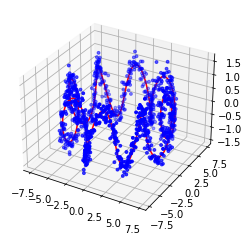

In [2]:
a = 6
b = 1
k = 10
u = np.linspace(0, 2 * np.pi, 1000)

v = k * u

x0 = (a + b * np.cos(0.8 * v)) * (np.cos(u))
y0 = (a + b * np.cos(0.8 * v)) * (np.sin(u))
z0 = b * np.sin(0.8 * v)

rox = 0.2
roy = 0.2
roz = 0.2
x = x0 + rox * np.random.normal(0, 1, len(x0))
y = y0 + roy * np.random.normal(0, 1, len(y0))
z = z0 + roz * np.random.normal(0, 1, len(z0))

X = np.array([x, y, z]).transpose()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x, y, z, c='b', cmap=plt.cm.Spectral, s=8)
ax.plot(x0, y0, z0, 'r', label='parametric curve')
plt.show()

Instantiate the class `DiffusionMaps` using `alpha=1`; `n_evecs=3`, because the first eigenvector is non-informative. Moreover, a Gaussian is used in the kernel construction.

In [3]:
dmaps = DiffusionMaps.create_from_data(data=X,
                                       alpha=0.5, eigenvectors_number=3,
                                       is_sparse=True, neighbors_number=100,
                                       kernel=GaussianKernel(epsilon=0.3))

Use the method `mapping` to compute the diffusion coordinates assuming `epsilon=0.3`.

In [4]:
diff_coords, evals, evecs = dmaps.fit()

Plot the second and third diffusion coordinates to reveal the embedded structure of the data.

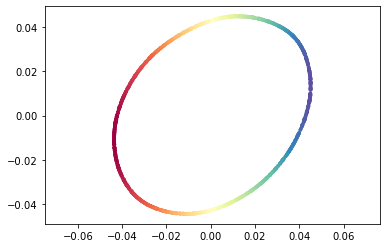

In [5]:
color = evecs[:, 1]
plt.scatter(diff_coords[:, 1], diff_coords[:, 2], c=color, cmap=plt.cm.Spectral, s=8)
plt.axis('equal')
plt.show()

Use the colormap to observe how the embedded structure is distributed in the original set.

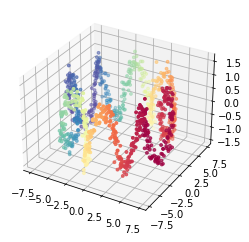

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x, y, z, c=color, cmap=plt.cm.Spectral, s=8)
plt.show()

Now, use an user defined kernel capable to handle this kind of data.

In [7]:
import scipy.spatial.distance as sd
import itertools
from UQpy import Kernel
class UserKernelDmaps(Kernel):
    def __init__(self, epsilon: float = None):
        self.epsilon = epsilon

    def pointwise_operator(self, point1, point2):
        pass

    def compute_default_epsilon(self, epsilon):
        if epsilon is None:
            # Compute a suitable epsilon when it is not provided by the user.
            # Compute epsilon as the median of the square of the euclidean distances
            epsilon = np.median(np.array(self.distance_pairs) ** 2)
        return epsilon

    def apply_method(self, data):
        self.distance_pairs = []
        if len(np.shape(data)) == 2:
            # Set of 1-D arrays
            self.distance_pairs = sd.pdist(data, 'euclidean')
        elif len(np.shape(data)) == 3:
            # Set of 2-D arrays
            # Check arguments: verify the consistency of input arguments.
            nargs = len(data)
            indices = range(nargs)
            pairs = list(itertools.combinations(indices, 2))

            self.distance_pairs = []
            for id_pair in range(np.shape(pairs)[0]):
                ii = pairs[id_pair][0]  # Point i
                jj = pairs[id_pair][1]  # Point j

                x0 = data[ii]
                x1 = data[jj]

                distance = np.linalg.norm(x0 - x1, 'fro')

                self.distance_pairs.append(distance)
        else:
            raise TypeError('UQpy: The size of the input data is not consistent with this method.')

        self.epsilon = self.compute_default_epsilon(self.epsilon)

        return np.exp(-sd.squareform(self.distance_pairs) ** 2 / (4 * self.epsilon))

Use the method `mapping` to compute the diffusion coordinates assuming `epsilon=0.3`.

In [8]:
dfm = DiffusionMaps.create_from_data(data=X,
                                     alpha=1, eigenvectors_number=3,
                                     kernel=UserKernelDmaps(epsilon=0.3))

TypeError: Can't instantiate abstract class UserKernelDmaps with abstract method kernel_entry

In [ ]:
diff_coord_new, evals, evecs = dfm.mapping()

color = evecs[:, 1]
plt.scatter(diff_coords[:, 1], diff_coords[:, 2], c=color, cmap=plt.cm.Spectral, s=8)
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x, y, z, c=color, cmap=plt.cm.Spectral, s=8)
plt.show()